#### Dependents

In [ ]:

using Roots, DataFrames, XSteam, Printf
using Graphs, Plots
using GraphPlot 
using GraphRecipes, LinearAlgebra
# # using PlotlyJS
# # using SankeyPlots

include("01-fluid_data.jl")
include("02-nodes.jl")
include("03-utilities.jl")
include("04-components.jl")
include("05-networks.jl")

In [ ]:
function run_track_temp(cyc::component_network,niter; do_plot = false, min_conv = .01, min_iter = 3, verbose = false,)
    TEMPS = get_multi_temp(cyc.nodes)
    dt = []
    for i = 1:niter
        advance(cyc)
        process(cyc)
        TEMPS = vcat(TEMPS,get_multi_temp(cyc.nodes))
        t_old = sum(TEMPS[i,:])
        t_new = sum(TEMPS[i+1,:])
        push!(dt,abs((t_old - t_new)))
        if (sum(dt[i]) < min_conv) && i > min_iter
            break
        end
    end
    iter_vec = [1:niter+1]

    if do_plot
        plot(dt)
    end

    if verbose
        @printf "\t Network converged at %i itteration, δT = %.3d\n" length(dt) dt[end]
    end
    return TEMPS,dt,iter_vec
end


## Default Cycles
### RANKINE

In [100]:
# cycle_vec   
#   1    divertor_circuit     
#   2    blanket_circuit
#   3    breeder_circuit
#   4    extraction_network,
#   5    rankine

# hx_vec  
#   1    divertor_heat_exchanger
#   2    blanket_heat_exchanger
#   3    breeder_heat_exchanger
#   4    boiler_heat_exchanger

sys = rankine_with_loops()
run_sys(sys; NITER = 5)
df = eval_sys(sys)
Wnet_cycle = df.Wout[5]-df.Win[5]
η_cycle = Wnet_cycle/df.Qtx[5]
η_total = (df.Wout[6]-df.Win[6])/df.Qh[6]
@printf "\t η_cyle = %.2f\n" η_cycle
@printf "\t η_tot = %.2f\n" η_total
display(df)
component_info(sys.cycles[4])
show_node_simple(sys.cycles[4])


Row,name,Qh,Qc,Qtx,Win,Wout
,Any,Any,Any,Any,Any,Any
1,divertor_network,3.66762e8,0,-3.73941e8,7.17936e6,0
2,blanket_network,4.66757e8,0,-4.75089e8,8.33146e6,0
3,breeder_network,9.92437e8,0,-9.96033e8,2.79515e6,0
4,Intermediate_loop,0,1.00765e9,9.94459e8,1.31869e7,0
5,Rankine,0,4.80116e8,8.50603e8,2.95718e6,3.73363e8
6,Total,1.82596e9,1.48776e9,0.0,3.44501e7,3.73363e8


	 η_cyle = 0.44
	 η_tot = 0.19
CYCLE OBJECT COMPONENT INFO => Intermediate_loop
	M-FLOW SRC
		 mflow = 1000.00 [kg/s] 	 fliud = helium 
	Circulator
		 mflow = 1000.00 [kg/s] 	 fliud = helium 	 W = 13.19 


		 Tin = 573.15  [K] 	 Tout = 575.69 
	HX1
		 mflow = 1000.00 [kg/s] 	 fliud = helium 	 Q = 373.94
		 Duty = 5.19 [MW]	 Tin = 575.69  [K] 	 Tout = 647.70 ΔH = 3.7394131288945055e8
		 Heat Mode Qset, 	 pressure mode: active, 	default ΔP: 0.20 	 Source Mode = transfer 
	HX2
		 mflow = 1000.00 [kg/s] 	 fliud = helium 	 Q = 475.09
		 Duty = 5.19 [MW]	 Tin = 647.70  [K] 	 Tout = 739.20 ΔH = 4.7508856739539295e8
		 Heat Mode Qset, 	 pressure mode: active, 	default ΔP: 0.20 	 Source Mode = transfer 
	HX3
		 mflow = 1000.00 [kg/s] 	 fliud = helium 	 Q = 996.03
		 Duty = 5.19 [MW]	 Tin = 739.20  [K] 	 Tout = 931.01 ΔH = 9.960328188884581e8
		 Heat Mode Qset, 	 pressure mode: active, 	default ΔP: 0.20 	 Source Mode = transfer 
	Boiler_hx
		 mflow = 1000.00 [kg/s] 	 fliud = helium 	 Q = -850.60
		 Duty = 5.19 [MW]	 Tin = 931.01  [K] 	 Tout = 767.20 ΔH = -8.506034991868066e8
		 Heat Mode Qset, 	 pressure mode: active, 	default ΔP: 0.20 	 Source Mode = transfer 
	Heat_Sink
		 mflow = 1000.00 [kg/s]

#### GRAPH PLOT

In [101]:
using Plots
# using GraphRecipes, LinearAlgebra
# gnew,  nms, edgelabel_mat, edgelabel_dict = network2graph2(sys.cycles[3]; verbose = false)
# gin,nms2, edgelabel_mat_int, edgelabel_dict_int = network2graph2(sys.cycles[4]; verbose = false)

f(x::Int64,y::Int64,Any) = 1.0
# gnew,  nms, edgelabel_mat, edgelabel_dict = network2graph2(sys.cycles[1]; verbose = false)
# p = Plots.plot(
#     graphplot(gnew, names = nms,
#     curves=true,
#     nodeshape   =  :rect,
#     edgelabel   = edgelabel_dict,
#     nodesize    = 0.1,
#     curvature_scalar = 0.01,
#     nodecolor = :lightblue,
#     edgewidth = f,
#     edge_label_box = false,
#     axis_buffer = 0.1)
# )
grp = Vector{Any}(undef,length(sys.cycles))
gobj = Vector{Any}(undef,length(sys.cycles))
elabs = Vector{Any}(undef,length(sys.cycles))
nprev = 0;
full_dict = Dict()

gfull,  comp_names, edgelabel_mat, full_dict, comp_dict = network2graph2(sys.cycles[1]; verbose = false)
offset = ne(gfull)

for idx = 2:5
    gobj,  nms, edgelabel_mat, edgelabel_dict, comp_dict = network2graph2(sys.cycles[idx]; verbose = false, component_dict = comp_dict)
    source_t = [keyval[1] for keyval ∈ collect(keys(edgelabel_dict))]
    target_t = [keyval[2] for keyval ∈ collect(keys(edgelabel_dict))]
    for i = 1:ne(gobj)
        full_dict[(source_t[i]+offset,target_t[i]+offset)] = edgelabel_dict[(source_t[i],target_t[i])]
    end
    comp_names = vcat(comp_names,nms)
    gfull = blockdiag(gfull,gobj)
    offset = ne(gfull)
end


for hx in sys.heat_exchangers
    hot_element     = hx.hot_stream
    cold_element    = hx.cold_stream

    #initializing src trg
    src = -1
    trg = -1
    Qmag = hot_element.Q
    hot_element.Q > 0 ? dir = 1 : dir = -1

    #first find by name
    hname = hx.hot_stream.name  # strings
    bname = hx.cold_stream.name

    hot_opt = findall(x -> x == hname,comp_names)   # node indexes

    # if more than 1 index, i.e. hot_elements have the same name
    # check the comp_dict to find matches
    if length(hot_opt) > 1
        for opt in hot_opt
            actual_element = comp_dict[opt]
            if get_inlet_temp(actual_element) == get_inlet_temp(hot_element)
                # actual element found
                println("Found element $(get_inlet_temp(actual_element)) and $(get_inlet_temp(hot_element))")
                src=opt
            end
        end
    else
        src = hot_opt[1]
    end
    cld_opt = findall(x-> x == bname,comp_names)
    if length(cld_opt) > 1
        for opt in cld_opt
            actual_element = comp_dict[opt]
            if get_inlet_temp(actual_element) == get_inlet_temp(cld_element)
                # actual element found
                println("Found element $(get_inlet_temp(actual_element)) and $(get_inlet_temp(cld_element))")
                src=opt
            end
        end
    else
        trg = cld_opt[1]
    end

    if dir == -1
        tmp = trg
        trg = src
        src = tmp
    end
    add_edge!(gfull,src,trg)
    full_dict[(src,trg)] = "Heat Exchanger Q = $(round(Qmag/10^6))"

end


Found element 651.4940579733632 and 651.4940579733632


Found element 744.0126627390359 and 744.0126627390359


In [102]:

using NetworkLayout
layout = Spring(Ptype=Float32)
positions = Spring(Ptype = Float64)(adjacency_matrix(gfull))
# typeof(position)
# y = positions[:,2
# display(x)
length(positions)
x = zeros(length(positions),1)
y = zeros(length(positions),1)
for (idx,pos) in enumerate(positions)
    x[idx]=pos[1] * 10
    y[idx]=pos[2] * 10
end
# position[1]

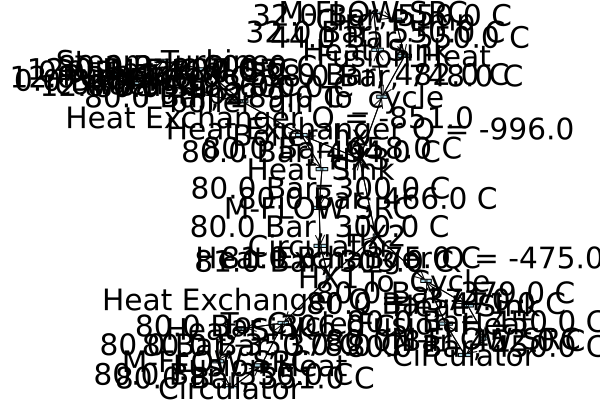

In [107]:

fig2=GraphRecipes.graphplot(gfull, names = comp_names,
    curves=false,
    x=x, y=y,
    nodeshape   =  :rect,
    edgelabel   = full_dict,
    nodecolor = :lightblue,
    nodesize    = 1,
    edge_label_box = false,
    fontsize = 20,
    axis_buffer = 0.0)

    display(fig2)

In [ ]:



fi, ax, p =GraphRecipes.graphplot(gfull, names = comp_names,
    curves=true,
    nodeshape   =  :rect,
    edgelabel   = full_dict,
    nodesize    = 0.1,
    curvature_scalar = 0.01,
    edge_label_box = false,
    axis_buffer = 0.1)


    
display(fi)
# Plots.savefig(gp,"Graph_1.pdf")
# # indexin(hx.hot_stream.name,comp_names)
# # collect(vert(gfull))
# display(comp_names)
# comp_names


In [ ]:
keym = collect(keys(edgelabel_dict))
[key[1] for key in keym]

#### SANKEY


In [ ]:
display(df)
@show sum(df.Qtx[1:3])
df.Qtx[4]-sum(df.Qtx[1:3]) - df.Qtx[5]

In [ ]:
using PlotlyJS
#                  0             1          2          3                   4               5               6           7
Energy_Sys = ["Fusion Core", "Divertor" , "blanket" , "breeder" ,"Intermediate_loop", "Thermal Cycle", "Cold Utility", "Electric"];

Edict = Dict() # Dict([source,targetr]) => value
FUSION_IDX      = 0
INTER_IDX       = 4
CYCLE_IDX       = 5
ELECTRIC_IDX    = 7
UTILITY_IDX     = 6

# imediate loops
for i = 1:3
    Edict[(FUSION_IDX,i)]     = df.Qh[i]/10^6
    Edict[(ELECTRIC_IDX,i)]   = df.Win[i]/10^6
    Edict[(i,INTER_IDX)]      = -df.Qtx[i]/10^6
    Edict[(i,UTILITY_IDX)]    = df.Qc[i]/10^6
end

Edict[(INTER_IDX,UTILITY_IDX)] = df.Qc[INTER_IDX] / 10^6

# primary cycles
Edict[(INTER_IDX,CYCLE_IDX)]    = df.Qtx[CYCLE_IDX] / 10^6
Edict[(CYCLE_IDX,ELECTRIC_IDX)] = df.Wout[CYCLE_IDX] / 10^6
Edict[(CYCLE_IDX,UTILITY_IDX)]  = df.Qc[CYCLE_IDX] / 10^6
Edict[(CYCLE_IDX,CYCLE_IDX)]    = df.Win[CYCLE_IDX] /10^6
 
# Qin, Qout, Win, Wout, Q_hx = calculate_circuit_net(sys.cycles[4])
# Edict[(INTER_IDX, CYCLE_IDX)] = sum(Q_hx)/10^6  # Net work
# Edict[(ELECTRIC_IDX, CYCLE_IDX)] = (Win)/10^6          # 
# Edict[(CYCLE_IDX, UTILITY_IDX)] = Qout/10^6

# Qin, Qout, Win, Wout, Q_hx_bred = calculate_circuit_net(sys.cycles[5])
# Edict[(CYCLE_IDX, ELECTRIC_IDX)]  = (Wout-Win)/10^6  # Net work
# Edict[(CYCLE_IDX, CYCLE_IDX)]     = (Win)/10^6          # 
# Edict[(CYCLE_IDX, UTILITY_IDX)]   = Qout/10^6


@show collect(Edict)
@show keys(Edict)

dict_k = keys(Edict)
@show source_t = [keyval[1] for keyval ∈ dict_k]
@show target_t = [keyval[2] for keyval ∈ dict_k]
@show vals_t    = [v for v in values(Edict)]

PlotlyJS.plot(sankey(
    node = attr(
      pad = 15,
      thickness = 20,
      label = Energy_Sys,
    ),
    link = attr(
      source    = source_t, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target    = target_t,
      value     = vals_t,
      label     = vals_t,
    )), 
  Layout(title_text="Basic Sankey Diagram", font_size=10)
)



#### BRAYTON


In [ ]:
sys = brayton_system()
run_sys(sys; NITER = 5)
df = eval_sys(sys)
display(df)


# PLOTTING
for hx in sys.heat_exchangers
    component_info(hx)
end

#convert to graph
gnew,nms, edgelabel_mat, edgelabel_dict = network2graph2(sys.cycles[4]; verbose = false)

gp = graphplot(gnew, names = nms,
    curves=true,
    nodeshape=:rect, 
    edge_label =  edgelabel_dict,
    nodesize = 0.1,
    curvature_scalar=0.01,
    axis_buffer = 0.1)

# # [e for e in edges(g)]
display(gp)


In [ ]:
df = eval_sys(sys)
display(df)

using PlotlyJS
#                  0             1          2              3             4               5           6
Energy_Sys = ["Fusion Core", "Divertor" , "blanket" , "breeder" ,"Thermal Cycle", "Cold Utility", "Electric"];

Edict = Dict() # Dict([source,targetr]) => value
FUSION_IDX      = 0
CYCLE_IDX       = 4
ELECTRIC_IDX    = 6
UTILITY_IDX     = 5

# imediate loops
for i = 1:3
    Edict[(FUSION_IDX,i)]     = df.Qh[i]/10^6
    Edict[(ELECTRIC_IDX,i)]   = df.Win[i]/10^6
    df.Qtx[i] < 0 ?  Edict[(i,CYCLE_IDX)] = -df.Qtx[i]/10^6  : Edict[(CYCLE_IDX,i)] = df.Qtx[i]/10^6  
    Edict[(i,UTILITY_IDX)]    = df.Qc[i]/10^6
end


# primary cycles
Edict[(CYCLE_IDX,ELECTRIC_IDX)] = df.Wout[CYCLE_IDX] / 10^6
Edict[(CYCLE_IDX,UTILITY_IDX)]  = df.Qc[CYCLE_IDX] / 10^6
Edict[(CYCLE_IDX,CYCLE_IDX)]    = df.Win[CYCLE_IDX] /10^6
 

@show collect(Edict)
@show keys(Edict)

dict_k = keys(Edict)
@show source_t = [keyval[1] for keyval ∈ dict_k]
@show target_t = [keyval[2] for keyval ∈ dict_k]
@show vals_t    = [v for v in values(Edict)]

PlotlyJS.plot(sankey(
    node = attr(
      pad = 15,
      thickness = 20,
      label = Energy_Sys,
    ),
    link = attr(
      source    = source_t, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target    = target_t,
      value     = vals_t,
      label     = vals_t,
    )), 
  Layout(title_text="Basic Sankey Diagram", font_size=10)
)

In [ ]:
g_main,names_main, edgelabel_main, edgelabel_dict_main  = network2graph(sys.cycles[5])

graphplot(g_main, names = names_main,
    curves=true,
    nodeshape=:rect, 
    nodesize = 0.1,
    curvature_scalar=0.01,
    axis_buffer = 0.1)

In [ ]:
# initialize cycle
cycle_network, reg, hx = brayton_network(500; Nc = 2,Pmin = 15.0, Nt = 1);
set_initial_pressure(cycle_network,15.0)
change_and_update_mass_flow(cycle_network,460.0)

# create regen heat exchanger (part of cycle)
regen   = heat_exchanger(cycle_network.elements[reg])

# Setup cycle
advance(regen)          # initializes heat exchanger inlet temperatuers
advance(cycle_network)  # initializes pressures / initial temperatures
process(regen)          # calculating
process(cycle_network)  # calcualating

# inialize coolant circuits
breeder_circuit,  divertor_circuit,  blanket_circuit = default_coolant_networks()
coolant_loops = [divertor_circuit, blanket_circuit, breeder_circuit]

# Self explanitory
ensure_pressure_match(breeder_circuit)
ensure_pressure_match(divertor_circuit)
ensure_pressure_match(blanket_circuit)

# set mass flow rates
change_and_update_mass_flow(breeder_circuit,17723.22)
change_and_update_mass_flow(divertor_circuit,760.0)
change_and_update_mass_flow(blanket_circuit,570.0)

# Initialize - first pass
for cool in coolant_loops
    advance(cool)
    process(cool)
end

circuits = [cycle_network,divertor_circuit,blanket_circuit,breeder_circuit]
# for c in circuits
#     show_comp_details(c)
# end


# create heat exchangers 
#   (These are "energy couplers" which allow different cycles/graphs to be connected)
#   For the default coolant networks, the element index is always 4
hx_div = heat_exchanger(cycle_network.elements[hx[1]],divertor_circuit.elements[4])
hx_blk = heat_exchanger(cycle_network.elements[hx[2]],blanket_circuit.elements[4])
hx_brd = heat_exchanger(cycle_network.elements[hx[3]],breeder_circuit.elements[4])

hx_rng = [hx_div, hx_blk, hx_brd]
for hx_inst = hx_rng
    advance(hx_inst)
    process(hx_inst)
    # show_details(hx_inst)
end
# for cool in coolant_loops
    # show_node_simple(cool)
# end
# show_node_simple()

# everything has been assembbled - MAIN loops
main_vec = [regen, hx_div,hx_blk, hx_brd, divertor_circuit, blanket_circuit,breeder_circuit,  cycle_network]
NITER = 10;
Temps = get_multi_temp(cycle_network.nodes)
iter = [0]
for i = 1:NITER
    for  obj in main_vec
        advance(obj)
        process(obj)
    end
    Temps = vcat(Temps,get_multi_temp(cycle_network.nodes))
    iter = vcat(iter,i)
end


### Testing Energy

In [ ]:
breeder = breeder_circuit

for el in breeder.elements
    if typeof(el) != mass_flow_source
    T1,P1,T2,P2 = get_TP(el.nodes)
    P1 = bar2pascal(P1)
    P2 = bar2pascal(P2)
    inprops,outprops = calculate_fluid_properties(el.nodes)

    cp_ave  = (inprops.cp + outprops.cp) /2
    vave    = (inprops.v + outprops.v) / 2

    pv1 = (P1*inprops.v + inprops.u)    * el.mass_flow
    pv2 = (P2*outprops.v + outprops.u)  * el.mass_flow
    ΔT,ΔP,Δu,Δh,Δs      = nodal_changes(el.nodes)

    @printf "%s\n" el.name
    @printf "\t P1 = %.2f \t T1 = %.2f \t u1 =  %.2f \t v1 = %e\n" P1 T1-273.15 inprops.u       inprops.v
    @printf "\t P2 = %.2f \t T2 = %.2f \t u2 =  %.2f \t v2 = %e\n " P2 T1-273.15 outprops.u     outprops.v
    # @printf "\t ΔP = %.2f \t ΔT = %.2f \t Δu = %.2f \t\t Δv = %.2f \n" (P2 - P1) (T2-T1) (outprops.u - inprops.u)  (outprops.v - inprops.v)
    # @printf "\t ΔP = %.2f \t ΔT = %.2f \t\t Δu = %.2f \n" ΔP ΔT Δu
    @printf "\t Δu = %.2f \n\t vΔP = %.2f  \n" Δu  (vave * ΔP)/0.9
    @printf "\t Δu = cp*ΔT = %.2f \n" cp_ave * ΔT * el.mass_flow
    @printf "\t Δh = cp*ΔT + vΔP = %.2f \n" (cp_ave * ΔT + vave * ΔP)
    @printf "\t ΔH = %.2f \n" (cp_ave * ΔT + vave * ΔP)*el.mass_flow/10^6
    @printf "\t ΔH = %.2f \n" el.ΔH/10^6
    # @printf "\t Inlet ṁ(Pv + u1) = %.2f \n\t Outlet ṁ(Pv + u2) = %.2f \n\t Out - In =  %.2f \t ΔH = %.2f \n " pv1/10^6 pv2/10^6 ((pv2 - pv1)/10^6) el.ΔH/10^6
    end
end





### Sankey Diagram

In [ ]:

using PlotlyJS
        #           0             1          2          3           4               5               6
Energy_Sys = ["Fusion Core", "Breeder" , "Divertor" , "Wall" , "Thermal Cycle", "Cold Utility", "Electric"];

Edict = Dict() # Dict([source,targetr]) => value
FUSION_IDX      = 0
CYCLE_IDX       = 4
ELECTRIC_IDX    = 6
UTILITY_IDX     = 5

for (i, circ) ∈ enumerate([breeder_circuit, divertor_circuit, blanket_circuit])
    
    Qin, Qout, Win, Wout, Q_hx = calculate_circuit_net(circ)

    Edict[(FUSION_IDX,i)]                   = Qin/10^6
    
    Edict[(i, UTILITY_IDX)]                 = Qout/10^6             # heat wasted
    
    Q_hx[1] < 0 ?  Edict[(i,CYCLE_IDX)] = -Q_hx[1]/10^6  : Edict[(CYCLE_IDX,i)] = Q_hx[1]/10^6       # heat to cycle
    
    Edict[(ELECTRIC_IDX,i)]= Win/10^6              # work into the systm
    
end

Qin, Qout, Win, Wout, Q_hx_bred = calculate_circuit_net(cycle_network)
Edict[(CYCLE_IDX, ELECTRIC_IDX)] = (Wout-Win)/10^6  # Net work
Edict[(CYCLE_IDX, CYCLE_IDX)] = (Win)/10^6          # 
Edict[(CYCLE_IDX, UTILITY_IDX)] = Qout/10^6


@show collect(Edict)
@show keys(Edict)

dict_k = keys(Edict)
source_t = [keyval[1] for keyval ∈ dict_k]
target_t = [keyval[2] for keyval ∈ dict_k]
vals_t    = [v for v in values(Edict)]

PlotlyJS.plot(sankey(
    node = attr(
      pad = 15,
      thickness = 20,
      label = Energy_Sys,
    ),
    link = attr(
      source    = source_t, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target    = target_t,
      value     = vals_t,
      arrowlen  = 100,

  )), 
  Layout(title_text="Basic Sankey Diagram", font_size=10)
)






### Graph Plot

In [ ]:
g_main,names_main, edgelabel_main, edgelabel_dict_main  = network2graph(cycle_network)
g_div,names_div, ell_div, el_dict_div                   = network2graph(divertor_circuit; verbose = true)
g_blk,names_blk, edgelabel_blk, el_dict_blk             = network2graph(blanket_circuit)
g_bred,names_bred, el_bred, el_dict_bred                = network2graph(breeder_circuit)

# graphplot(g_main, names = names_main,
#     curves=true,
#     nodeshape=:rect, 
#     nodesize = 0.1,
#     curvature_scalar=0.01,
#     axis_buffer = 0.1)


# graphplot(g_div, names = names_div,
#     curves=true,
#     nodeshape=:rect, 
#     nodesize = 0.1,
#     curvature_scalar=0.01,
#     axis_buffer = 0.1)



In [ ]:
ed=edges(g_main)

# dump(iterate(ed))
# dump(g_main)
methods
# supertype(typeof(ed))


### Nodes


## TDS

In [ ]:



# create heat exchangers 
#   (These are "energy couplers" which allow different cycles/graphs to be connected)
#   For the default coolant networks, the element index is always 4
hx_div = heat_exchanger(cycle_network.elements[hx[1]],divertor_circuit.elements[4])
hx_blk = heat_exchanger(cycle_network.elements[hx[2]],blanket_circuit.elements[4])
hx_brd = heat_exchanger(cycle_network.elements[hx[3]],breeder_circuit.elements[4])

hx_rng = [hx_div, hx_blk, hx_brd]


process(cycle_network)
advance(cycle_network)

for cyc in [cycle_network,blk,bred,div]
    advance(cyc)
    process(cyc)
end

idx_coolant_hx = 4
hx_div = heat_exchanger(cycle_network.elements[6],div.elements[4])
hx_blk = heat_exchanger(cycle_network.elements[7],blk.elements[4])
hx_brd = heat_exchanger(cycle_network.elements[8],bred.elements[4])


for hx in [hx_div,hx_blk,hx_brd]
    advance(hx)
    process(hx)
    # show_details(hx)
end

for cyc in [cycle_network,blk,bred,div]
    advance(cyc)
    process(cyc)
    # element_io_temp(cyc)
    # check_energy_balance(cyc; sum_only = true, show_math = false)
    # check_entropy_balance(cyc; sum_only = true)
end

niter = 50
for i = 1:niter
    for el in [div,hx_div,blk,hx_blk,bred,hx_brd,cycle_network]
        advance(el)
        process(el)
    end
end

nodal_vs_element_H(cycle_network)
element_QW(cycle_network)
element_QW(bred)
element_QW(blk)
element_QW(div)


for hx in [hx_div,hx_blk,hx_brd]
    show_details(hx)
end


In [ ]:

g_main,names_main, edgelabel_main, edgelabel_dict_main  = network2graph(cycle_network)
g_div,names_div, ell_div, el_dict_div                   = network2graph(div; verbose = true)
g_blk,names_blk, edgelabel_blk, el_dict_blk             = network2graph(blk)
g_bred,names_bred, el_bred, el_dict_bred                = network2graph(bred)

# graphplot(g_main, names = names_main,
#     curves=true,
#     nodeshape=:rect, 
#     nodesize = 0.1,
#     curvature_scalar=0.01,
#     axis_buffer = 0.1)


graphplot(g_div, names = names_div,
    curves=true,
    nodeshape=:rect, 
    nodesize = 0.1,
    curvature_scalar=0.01,
    axis_buffer = 0.1)


In [ ]:
for cyc in [cycle_network,blk,bred,div]
    element_io_temp(cyc)
    check_energy_balance(cyc; sum_only = true, show_math = false)
    check_entropy_balance(cyc; sum_only = true)
end


for hx in [hx_div,hx_blk,hx_brd]
    show_details(hx)
end



In [ ]:
nodal_vs_element_H(bred)

# @show bred.elements[1].name bred.elements[1].ΔH
# @show bred.elements[2].name bred.elements[2].ΔH
# @show bred.elements[3].name bred.elements[3].ΔH
# @show bred.elements[4].name bred.elements[4].ΔH
# @show bred.elements[5].name bred.elements[5].ΔH
# print_params(bred.elements[5].params)
# element_io_any(bred,:u)
# element_io_any(bred,:T)
# element_io_any(bred,:cp)

element_io_any(bred,:P)
# element_io_any(bred,:v)
element_QW(bred)


In [ ]:
# attaching heat exchangers
idx_coolant_hx = 4
hx_div = heat_exchanger(cycle_network.elements[6],div.elements[4])
hx_blk = heat_exchanger(cycle_network.elements[7],blk.elements[4])
hx_brd = heat_exchanger(cycle_network.elements[8],bred.elements[4])

In [ ]:
for hx in [hx_div,hx_blk,hx_brd]
    advance(hx)
    process(hx)
    # show_details(hx)
end

for cyc in [cycle_network,blk,bred,div]
    advance(cyc)
    process(cyc)
    # element_io_temp(cyc)
    # check_energy_balance(cyc; sum_only = true, show_math = false)
    # check_entropy_balance(cyc; sum_only = true)
end

niter = 50
for i = 1:niter
    for el in [div,hx_div,blk,hx_blk,bred,hx_brd,cycle_network]
        advance(el)
        process(el)
    end
end

for cyc in [cycle_network,blk,bred,div]
    element_io_temp(cyc)
    check_energy_balance(cyc; sum_only = true, show_math = false)
    check_entropy_balance(cyc; sum_only = true)
end


for hx in [hx_div,hx_blk,hx_brd]
    show_details(hx)
end


## VERIFICATIONS

In [ ]:
using Roots, DataFrames, XSteam, Printf
include("01-fluid_data.jl")
include("02-nodes.jl")
include("03-utilities.jl")
include("04-components.jl")


In [ ]:
T1 = 15 + 273.156
P1 = 15.17
P2 = 56.87
rp = P2/P1

cp_he = 5.1926e3

khe = 1.666
kcoef = (khe-1)/khe
@show T2s = T1 * (rp^kcoef)
@show ws = cp_he * (T2s - T1)



para = component_network_params(T1,P1,600,:helium)
nodes                   = init_gas_nodes(3)
component_vector        = Vector{model_component}(undef,1)
component_vector[1]     = mass_flow_source(nodes[1:2];  params = mass_flow_source_paremeter(1.0,  :helium))


cparams = gas_working_element_parameters(rp = 56.87/15.17, η = 1.0)
push!(component_vector,gas_compressor(nodes[2:3];params = cparams, name = "compressor"))
thermal_network  = component_network(para,nodes,component_vector,1.0,"simple_test")
set_initial_temperatures(thermal_network)
set_initial_pressure(thermal_network)

advance(thermal_network)
process(thermal_network)

element_io_temp(thermal_network)
show_node_simple(thermal_network)
element_QW(thermal_network)

In [ ]:

mflow = 1.0
# simple test of pump
para = component_network_params(550,10,600,:pbli)

nodes                   = init_liq_nodes(3)
component_vector        = Vector{model_component}(undef,1)
component_vector[1]     = mass_flow_source(nodes[1:2];  params = mass_flow_source_paremeter(working_fluid = para.working_fluid, mass_flow = mflow))
push!(component_vector, init_simple_pump(nodes[2:3]))

thermal_network  = component_network(para,nodes,component_vector,1.0,"simple_test")
#show_node(cnet)
set_initial_temperatures(thermal_network)
set_initial_pressure(thermal_network)
set_pressure(nodes[3],15)
# show_node(thermal_network)
# show_comp_nodes(thermal_network)
change_and_update_mass_flow(thermal_network,100.0)
show_node_simple(thermal_network)

advance(thermal_network)
process(thermal_network)

show_params(thermal_network.elements[2])

show_node_simple(thermal_network)
element_io_temp(thermal_network)
check_energy_balance(thermal_network; sum_only = true, show_math = false)
check_entropy_balance(thermal_network; sum_only = true)
element_io_any(thermal_network,:T)
element_QW(thermal_network)

## Testing Graphs
#### Dependencies

In [ ]:
using Graphs
using Roots, DataFrames, XSteam, Printf
using GraphPlot 
using Plots, GraphRecipes
# using CairoMakie
# using GraphMakie

include("01-fluid_data.jl")
include("02-nodes.jl")
include("03-utilities.jl")
include("04-components.jl")


##### PUMP

In [ ]:
nodes = init_water_nodes(2)
show_node(nodes)
pump_nodes = siso_nodes(nodes)
water_pump = h20_pump(nodes = pump_nodes; params = h20_pump_parameters(0.8))
show_node(nodes)
initialize(water_pump,.1,12)
advance(water_pump)
process(water_pump)

# calculate_fluid_properties(nodes)


#### TURBINE

SISO TURBINE

In [ ]:
nodes = init_water_nodes(2)
set_temperature(nodes[1], 873.15)
turbine_nodes = siso_nodes(nodes)
water_turb = h20_turbine(nodes = turbine_nodes; params = h20_turbine_parameters(1.0))
show_node(nodes)
initialize(water_turb,150,40)
advance(water_turb; verbose = true)
show_node(nodes)
process(water_turb)



SIMO Turbine

In [ ]:
# all in
nodes = init_water_nodes(7)
component_vector = Vector{model_component}(undef,6)


turbine_nodes = simo_nodes(nodes[5],nodes[6:7])
ofw_nodes     = miso_nodes([nodes[6],nodes[2]],nodes[3])
pump1_nodes = siso_nodes(nodes[1:2])
pump2_nodes = siso_nodes(nodes[3:4])

boiler_nodes = siso_nodes(nodes[4:5])
condensor_nodes = siso_nodes(nodes[7],nodes[1])


component_vector[1] = h20_pump(nodes = pump1_nodes; params = h20_pump_parameters(1.0))
component_vector[2] = h20_open_feedwater_heater(nodes = ofw_nodes)
component_vector[3] = h20_pump(nodes = pump2_nodes; params = h20_pump_parameters(1.0))


set_temperature(nodes[5], 873.15)
set_pressure(nodes[5],150)

turbine_nodes = simo_nodes(nodes[1],nodes[2:3])

water_turb = h20_simo_turbine(nodes = turbine_nodes; params = h20_turbine_parameters(1.0))
show_node(nodes)
initialize(water_turb,150.0,[12.0;.1])
# advance(water_turb; verbose = true)
show_node(nodes)
advance(water_turb; verbose = true)
show_node(nodes)
process(water_turb)
@show water_turb.ΔH
@show water_turb.W
water_turb.mass_flow


### FULL RANKINE EVALUATION

In [ ]:
# all in
nodes = init_water_nodes(7)
component_vector = Vector{model_component}(undef,6)


turbine_nodes = simo_nodes(nodes[5],nodes[6:7])
ofw_nodes     = miso_nodes([nodes[6],nodes[2]],nodes[3])
pump1_nodes = siso_nodes(nodes[1:2])
pump2_nodes = siso_nodes(nodes[3:4])

boiler_nodes = nodes[4:5]
condensor_nodes = [nodes[7],nodes[1]]
set_temperature(nodes[5],600+273.15)

component_vector[1] = h20_pump(nodes = pump1_nodes; params = h20_pump_parameters(1.0))
component_vector[5] = h20_open_feedwater_heater(nodes = ofw_nodes)
component_vector[3] = h20_pump(nodes = pump2_nodes; params = h20_pump_parameters(1.0))
component_vector[4] = simple_boiler(boiler_nodes; name_string = "boiler")
component_vector[2] = h20_simo_turbine(nodes = turbine_nodes; params = h20_turbine_parameters(1.0))
component_vector[6] = simple_condensor(condensor_nodes)

#initializing
initialize(component_vector[1], .1,12)
initialize(component_vector[3], 12,150.0)
initialize(component_vector[2],150.0,[12,0.1])
para = component_network_params(Tmin = 273, Pmin = 0.1, Tmax = 873.12, working_fluid = :water)
cm = component_network(para,nodes,component_vector,1.0,"Rankine")
advance(cm)
process(cm)
advance(cm)
process(cm)
show_node_simple(cm)

Qin, Qout, Win, Wout, Q_hx = calculate_circuit_net(cm)
element_QW_simple(cm)
node_enthalpies(cm)
(abs(Wout) - Win) / Qin

In [ ]:
cycle_network = brayton_network(5; Nc = 2, Nt = 1);
g,nms, edgelabel_mat, edgelabel_dict = network2graph(cycle_network)
incidence_matrix(g)
@show edges(g)
@show length(nms)

graphplot(g, 
    edgelabel=edgelabel_dict, 
    curves=false,
    method = :stress, 
    nodeshape=:ellipse, 
    nodesize = 0.2,
    curvature_scalar=0.1)



#### Initialization

In [ ]:
cycle_network = brayton_network(5; Nc = 2, Nt = 1);
num_edge    = elem_count(cycle_network)
num_vert    = node_count(cycle_network)
g           = DiGraph(num_vert)



nms = []
for el in cycle_network.elements
    add_edge!(g,el.nodes.A.node_num, el.nodes.B.node_num)
    push!(nms,el.name)
    display("Node added :  $(el.nodes.A.node_num) to $(el.nodes.B.node_num)  <=> $(el.name) ")
end
@show nms

#### Plotting


In [ ]:
using GraphRecipes, Plots
# using smallgraph
graphplot(g)
incidence_matrix(g)
    # nodesize=0.1,
    # edgelabel = nms)
    # layout=circular_layout)
    
    # nodeshape = :rect,
          #      elabels_color=[:black for i in 1:ne(g)],
          #      elabels_fontsize=12,
          #      curves = true)

In [ ]:
e=edges(g)
@show Base.eltype(g)

for ee in e
    @show typeof(ee)
end

has_edge(g,1,2)
has_vertex(g,1,2)

In [ ]:
# cpin   = (0.195 - 9.116e-6 .* Tin) .* 1000  # J/kgK
# vin    = 1/(10520.35 - 1.19051 .* Tin)      # m3/kg
# cp_ref = (0.195 - 9.116e-6 .* Tin) .* 1000
# specific entropy of lead lithium, with reference to 508 K
bar2pascal(P_bar) = P_bar * 100000

Tref = 508
Pref = bar2pascal(1)


a = 0.195*1e3
b = 9.11e-6*1000
s_pbli(T)   = a*log(T) - b*T - 1210.316002277804        # found by integrating specific heat formulas
v(T)        = 1/(10520.35 - 1.19051 .* T)               # m3/kg
cp(T)       = 195 - .0009116 * T
u(T)        = 195 * T - .0009116/2 * T^2                # integral of cp
href        = u(Tref) + Pref*v(Tref)
h(T,p)       = u(T) + v(T) * bar2pascal(P) - href
href        = u(Tref) + Pref*v(Tref)
href        = u(Tref) + Pref*v(Tref)






# mutable struct fluid_props
#     cp
#     v
#     s
#     h 
# end

pbli = fluid_props((T -> cp(T)),(T -> vin(T)), (T-> s_pbli(T)))

pbli.cp_fun(500)